# GWT Example 1 -- One dimensional transport in steady flow field

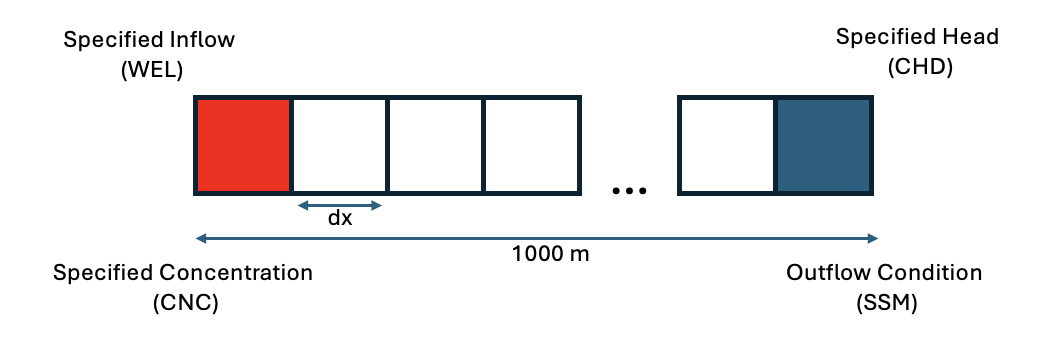

This example demonstrates the behavior of the GWT Model for several different advection schemes, cell sizes, and time steps.  The example is based on the figure shown above.  A 1000-m section is discretized into 1 layer, 1 row, and a variable number of columns.  Water is injected into the first cell using the Well Package.  The cell in the last column is assigned as a constant head using the Constant-Head (CHD) Package.  

For the GWT Model, the concentration in the first cell is fixed at a value of 1.0 using the Constant Concentration (CNC) Package.  For the last cell in the model, solute leaves the model at the simulated concentration in the cell.  This outflow condition happens by default, but requires the Source and Sink Mixing (SSM) Package to be active for the GWT Model.

The problem is designed so that the solute front reaches a distance of 500 m after 2000 days of injection.  There is no specified dispersion, so any observed mixing in the model is due to numerical dispersion.  Combating the effects of numerical dispersion is one of the largest challenges with solute transport modeling.  This notebook is intended to highlight several of the factors that affect numerical dispersion.

The goal of this example is to evaluate the behavior of the GWT Model for the following:
* advection scheme (central, upstream, TVD)
* temporal resolution
* spatial resolution

In [ ]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import flopy
import ex1

figsize = (6, 4)

## Base Case

In the corresponding python script `ex1.py` the `get_sim` function will return a flopy simulation object for this example.  We will use this function to the create the simulations in this notebook.

In [ ]:
# Run the base example
sim = ex1.get_ex1_sim("ex1", dx=10.0, dt=20.0, advscheme="tvd")
sim.write_simulation(silent=True)
sim.run_simulation(silent=True)
cobj = sim.gwt[0].output.concentration()
concentrations = cobj.get_alldata()

with flopy.plot.styles.USGSPlot() as fs:
    fig, axes = plt.subplots(2, 1, figsize=figsize, tight_layout=True)

    # Concentration versus distance
    ax = axes[0]
    ax.plot(
        sim.gwt[0].modelgrid.xcellcenters.flatten(),
        concentrations[-1, 0, 0, :],
    )
    ax.set_xlabel("Distance, in meters")
    ax.set_ylabel("Concentration")

    # Concentration versus time
    ntimes, nlay, nrow, ncol = concentrations.shape
    ax = axes[1]
    ax.plot(
        cobj.times,
        concentrations[:, 0, 0, int(ncol / 4)],
    )
    ax.set_xlabel("Time, in days")
    ax.set_ylabel("Concentration")

## Exercise A -- Advection Schemes

Run the model for the three different advection schemes supported by the Advection (ADV) Package.  These schemes include central in space ("central"), upstream weighted ("upstream"), and total-variation diminishing ("tvd").  Make plots of concentration versus distance for the end of the time step (t = 2000 days) and concentration versus time for a cell located at x = 250 m.  It may be helpful to create a function like the following, which can also be used for the subsequent exercises.

```
def run_model(dx=10.0, dt=20.0, advscheme="tvd"):
    sim = ex1.get_ex1_sim("ex1", dx=dx, dt=dt, advscheme=advscheme)
    sim.write_simulation(silent=True)
    sim.run_simulation(silent=True)
    cobj = sim.gwt[0].output.concentration()
    concentrations = cobj.get_alldata()
    x = sim.gwt[0].modelgrid.xcellcenters.flatten()
    t = cobj.times
    return x, t, concentrations
```

In [ ]:
# Create concentration/distance and concentration/time plots
# for the three advection schemes (upstream, central, and tvd)


def run_model(dx=10.0, dt=20.0, advscheme="tvd"):
    sim = ex1.get_ex1_sim("ex1", dx=dx, dt=dt, advscheme=advscheme)
    sim.write_simulation(silent=True)
    sim.run_simulation(silent=True)
    cobj = sim.gwt[0].output.concentration()
    concentrations = cobj.get_alldata()
    x = sim.gwt[0].modelgrid.xcellcenters.flatten()
    t = cobj.times
    return x, t, concentrations


results = {}
for advscheme in ["upstream", "central", "tvd"]:
    results[advscheme] = run_model(advscheme=advscheme)

with flopy.plot.styles.USGSPlot() as fs:
    fig, axes = plt.subplots(2, 1, figsize=figsize, tight_layout=True)

    # Concentration versus distance
    ax = axes[0]
    for advscheme, (x, t, c) in results.items():
        ax.plot(x, c[-1, 0, 0, :], label=advscheme)
    ax.set_xlabel("Distance, in meters")
    ax.set_ylabel("Concentration")
    ax.legend()

    # Concentration versus time
    ax = axes[1]
    for advscheme, (x, t, c) in results.items():
        ntimes, nlay, nrow, ncol = c.shape
        ax.plot(t, c[:, 0, 0, int(ncol / 4)], label=advscheme)
    ax.set_xlabel("Time, in days")
    ax.set_ylabel("Concentration")
    ax.legend()

## Exercise B -- Spatial discretization

Evaluate the effect of cell size on transport behavior.  Use cell sizes of dx = 1, 10, and 20.  Make plots of concentration versus distance and concentration versus time as done for the previous example.

In [ ]:
# Evaluate the effect of cell size.  Run the model with dx = 1, 10, 20
# and plot the results

results = {}
for dx in [1, 10, 20]:
    results[dx] = run_model(dx=dx)

with flopy.plot.styles.USGSPlot() as fs:
    fig, axes = plt.subplots(2, 1, figsize=figsize, tight_layout=True)

    # Concentration versus distance
    ax = axes[0]
    for dx, (x, t, c) in results.items():
        ax.plot(x, c[-1, 0, 0, :], label=f"dx={dx} m")
    ax.set_xlabel("Distance, in meters")
    ax.set_ylabel("Concentration")
    ax.legend()

    # Concentration versus time
    ax = axes[1]
    for dx, (x, t, c) in results.items():
        ntimes, nlay, nrow, ncol = c.shape
        ax.plot(t, c[:, 0, 0, int(ncol / 4)], label=f"dx={dx} m")
    ax.set_xlabel("Time, in days")
    ax.set_ylabel("Concentration")
    ax.legend()

## Exercise C -- Temporal discretization

Evaluate the effect of time-step size on transport behavior.  Use time-step sizes of dt = 1, 10, and 20.  Make plots of concentration versus distance and concentration versus time as done for the previous examples.

In [ ]:
# Evaluate the effect of time step size.  Run the model with dt = 1, 10, 20
# and plot the results

results = {}
for dt in [1, 10, 20]:
    results[dt] = run_model(dt=dt)

with flopy.plot.styles.USGSPlot() as fs:
    fig, axes = plt.subplots(2, 1, figsize=figsize, tight_layout=True)

    # Concentration versus distance
    ax = axes[0]
    for dt, (x, t, c) in results.items():
        ax.plot(x, c[-1, 0, 0, :], label=f"dt={dt} day")
    ax.set_xlabel("Distance, in meters")
    ax.set_ylabel("Concentration")
    ax.legend()

    # Concentration versus time
    ax = axes[1]
    for dt, (x, t, c) in results.items():
        ntimes, nlay, nrow, ncol = c.shape
        ax.plot(t, c[:, 0, 0, int(ncol / 4)], label=f"dt={dt} day")
    ax.set_xlabel("Time, in days")
    ax.set_ylabel("Concentration")
    ax.legend()